# Simultaneous Imitation

## Abstract

TODO


## Imitation Task
This is the video, subjects saw the video and imitated movements **simultaneously**.
<iframe width="560" height="315" src="https://www.youtube.com/embed/2hhV0Ev2PDQ"></iframe>


## Subject heatmap and Grand Average

We calculate the grand average data heatmap for fixation, data ranges are [0, 48] and [0, 30] for 
(x, y) respectively so we need to filter data as the next scatter plot shows.


97.96991508986682% of data inside this range


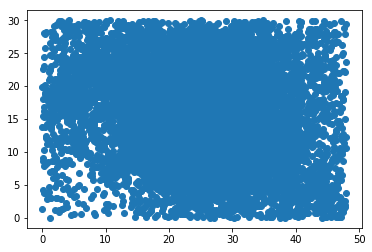

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('./source_data/data.csv')

x0 = data['x_start']  # index = 2
y0 = data['y_start']  # index = 3

mask = [(x > 0) and (x < 48) and (y > 0) and (y < 30) for x, y in zip(x0, y0)]
print("{}% of data inside this range".format(100*sum(mask)/len(mask)))
plt.scatter(x0[mask], y0[mask])
plt.show()


## Creating a trial-only mask and modify x-y coordinates
From all data points we need to use only those points inside useful trial intervals so we need to mask them, we also
modify x-y coords that were normalized by 48, 30


In [43]:
import pandas as pd
import numpy as np


data = pd.read_csv('./source_data/data.csv')
t0 = data['time_start'].as_matrix()
subject = data['subject'].as_matrix() - 1  # subject1 is 0 in python

trial_data = pd.read_excel('./source_data/Frames.xlsx')
ids = trial_data['id'].as_matrix()

# mark trials 1 to 5 with that number, passive observation as 0, -1 everything else
# take out the invalid subjects, marked with 0 as id
mask = [i for i in range(len(ids)) if ids[i] > 0]

# transform frame tags to time, videos were at 30fps
intervals = [(trial_data['passivei'].as_matrix()[mask]/30, trial_data['passivef'].as_matrix()[mask]/30), 
             (trial_data['t1i'].as_matrix()[mask]/30, trial_data['t1f'].as_matrix()[mask]/30), 
             (trial_data['t2i'].as_matrix()[mask]/30, trial_data['t2f'].as_matrix()[mask]/30), 
             (trial_data['t3i'].as_matrix()[mask]/30, trial_data['t3f'].as_matrix()[mask]/30), 
             (trial_data['t4i'].as_matrix()[mask]/30, trial_data['t4f'].as_matrix()[mask]/30), 
             (trial_data['t5i'].as_matrix()[mask]/30, trial_data['t5f'].as_matrix()[mask]/30)]

trial_id = np.zeros(t0.shape) - 1
for data_index in range(len(trial_id)):
    for tuple_index in range(len(intervals)):
        interval_low = intervals[tuple_index][0]
        interval_high = intervals[tuple_index][1]
        low = interval_low[subject[data_index]]
        high = interval_high[subject[data_index]]
        
        if low < t0[data_index] < high:
            trial_id[data_index] = tuple_index
            
# add this mask to data csv
data['trial_id'] = trial_id

# finally modify x-y


# make a modified file
data.to_csv('./source_data/data_modified.csv')


/home/babybrain/PycharmProjects/accelerometer-data/venv/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/babybrain/PycharmProjects/accelerometer-data/venv/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/home/babybrain/PycharmProjects/accelerometer-data/venv/lib/python3.5/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/home/babybrain/PycharmProjects/accelerometer-data/venv/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/babybrain/PycharmProjects/accelerometer-data/venv/lib/python3.5/site-packages/ipykernel_launcher.py:18: FutureWarning: Met

Taking this in mind we resize data to real monitor setting and we create the heatmap:


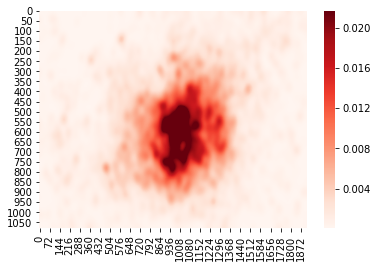

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import cv2


# import data
data = pd.read_csv('./source_data/data.csv')
x0_resized = data['x_start']*1920/48  # index = 2
y0_resized = data['y_start']*1080/30  # index = 3

duration = data['duration']  # index = 7
mask = [(x > 0) and (x < 48) and (y > 0) and (y < 30) for x, y in zip(x0, y0)]

# translate to a heatmap
heatmap = np.zeros((1080, 1920))
for x, y, t, valid in zip(x0_resized, y0_resized, duration, mask):
    if valid:
        heatmap[int(y), int(x)] = t

# gaussian filter heatmap
blurred_heatmap = cv2.GaussianBlur(heatmap, (0, 0), 20)

sb.heatmap(blurred_heatmap, cmap='Reds', robust=True)
plt.show()


## Fixation/Saccade/SmoothPursuit Characterization Overview

We calculate mean fixation duration and number as grand-average.


Grand average fix-time 0.3400095825985397[s]
Grand average sacc-time 0.06574199217906337[s]
Grand average smooth-time 0.9956280560552708[s]


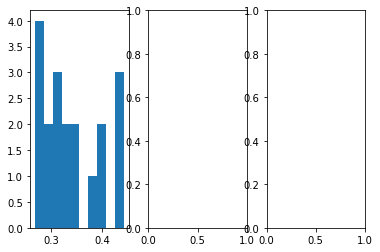

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# create a function that averages duration per subject
def group_average_duration(dataframe, event_id):
    times = dataframe['duration']
    subject_mask = dataframe['subject']
    type_mask = dataframe['type'] 
    n_subjects = subject_mask.max()
    mean_data = np.empty(n_subjects)
    
    for n in range(n_subjects):
        subject_data = [time for index, time in enumerate(times) 
                        if subject_mask[index] == n+1 and type_mask[index] == event_id]
        mean_data[n] = np.nanmean(subject_data)
    return mean_data


# import data
data = pd.read_csv('./source_data/data.csv')

# average events
data_type = dict(sacc=1, fix=2, smp=3)  # smp = smooth pursuit
sacc_duration = group_average_duration(data, data_type['sacc'])
fix_duration = group_average_duration(data, data_type['fix'])
smp_duration = group_average_duration(data, data_type['smp'])


print("Grand average fix-time {}[s]".format(np.nanmean(fix_duration)))
print("Grand average sacc-time {}[s]".format(np.nanmean(sacc_duration)))
print("Grand average smooth-time {}[s]".format(np.nanmean(smp_duration)))

# plot average duration for subjects histogram
fig, axes = plt.subplots(1, 3)
axes[0].hist(fix_duration)
axes[1].hist(sacc_duration)
axes[2].hist(smp_duration)
plt.show()


## Cut acc signal according to trials frames (checkout if matlab was done right)


In [ ]:
# TODO: Make a function that cuts signal according to frames in trial, remember that acc signal is in time, 
# we need TTL = when acc was ON in frame
print("!")


## Calculate Performance Using MSE
We calculate performance MSE in 4 sensors (per subject, per trial, grand average)


In [ ]:
# TODO


## Calculate Gaze-time per zone


In [ ]:
# TODO

